In [5]:
import os
import mdtraj
import json
import numpy as np

import torch
from tqdm import tqdm

import torch
import torch.nn as nn
import glob

import mdtraj

import sys
sys.path.append("..")
from module import dataset

from simulate import load_model, load_molecule

import matplotlib.pyplot as plt

2025-03-20 13:36:05,611 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-03-20 13:36:05,612 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [ ]:
###
# Set checkpoint_path to the model directory or checkpoint you want to test
# Set input path to the course grained trajectory you want to generate predictions for

checkpoint_path = "/home/argon/Stuff/harmonic_net_2025.02.01/terms/model_high_density_2025.02.09_4fs_3ID4_s50_CA_lj_angleNull_dihedralNull_cutoff2_seq6_harAD_termAD__wd0_plateaulr5en4_0.1_0_1en6_1en7_bs8"
input_path = "/home/argon/Stuff/harmonic_net_2025.02.01/cg_high_density_2025.02.09_4fs_s50_CA_lj_bondNull_angleXCX_dihedralX/3ID4"

In [7]:
device = "cuda"

if os.path.isdir(checkpoint_path):
    checkpoint_path = os.path.join(checkpoint_path, "checkpoint-best.pth")
checkpoint_dir = os.path.dirname(checkpoint_path)

prior_path = os.path.join(checkpoint_dir, "priors.yaml")
assert os.path.exists(prior_path)
prior_params_path = os.path.join(checkpoint_dir, "prior_params.json")

psf_path = glob.glob(os.path.join(input_path, "processed/*_processed.psf"))[0]

# Load forcefield terms
with open(f"{prior_params_path}", 'r') as file:
    prior_params = json.load(file)

# Load the model
model = load_model(checkpoint_path, device, extra_model_config={
    "harmonic_net_return_terms": True,
    "derivative": False,
})


--- Model ---
 TorchMD_Net_Harmonic(
  (representation_model): TorchMD_GN_Ext(hidden_channels=128, num_filters=128, num_layers=4, num_rbf=20, rbf_type=expnorm, trainable_rbf=True, activation=silu, neighbor_embedding=None, cutoff_lower=2.0, cutoff_upper=12.0, aggr=add, sequence_basis_radius=6, sequence_basis_onehot=False)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (extra_output_models): ModuleDict()
  (harmonic_model): HarmonicModel(
    (angle_network): Sequential(
      (0): Linear(in_features=384, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
    (dihedral_network): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): SiLU()
      (2): 

In [8]:
mol, embeddings = load_molecule(prior_path, prior_params, input_path, use_box=False, verbose=True)

Topology:    /home/argon/Stuff/harmonic_net_2025.02.01/cg_high_density_2025.02.09_4fs_s50_CA_lj_bondNull_angleXCX_dihedralX/3ID4/processed/3ID4_processed.psf
Prior:       /home/argon/Stuff/harmonic_net_2025.02.01/terms/model_high_density_2025.02.09_4fs_3ID4_s50_CA_lj_angleNull_dihedralNull_cutoff2_seq6_harAD_termAD__wd0_plateaulr5en4_0.1_0_1en6_1en7_bs8/priors.yaml
Coordinates: /home/argon/Stuff/harmonic_net_2025.02.01/cg_high_density_2025.02.09_4fs_s50_CA_lj_bondNull_angleXCX_dihedralX/3ID4/raw/coordinates.npy
Embeddings:  /home/argon/Stuff/harmonic_net_2025.02.01/cg_high_density_2025.02.09_4fs_s50_CA_lj_bondNull_angleXCX_dihedralX/3ID4/raw/embeddings.npy
Box:         <disabled>
Shape (20000, 93, 3)
Mol: (93, 3, 1) 0 []


In [9]:
model_kwargs = {}

sequence = None
if hasattr(model.representation_model, "sequence_basis_radius") and \
    model.representation_model.sequence_basis_radius != 0:
    print("Generating sequence info...")
    sequence = dataset.build_sequence_for_mol(mol)
    model_kwargs["s"] = torch.as_tensor(sequence, device=device)
elif hasattr(model.representation_model, "adjacency_size") and \
    model.representation_model.adjacency_size > 0:
    print("Generating adjacency info...")
    sequence = dataset.build_adjacency_for_mol(mol, 3)
    model_kwargs["s"] = torch.as_tensor(sequence, device=device)
if hasattr(model, "harmonic_model"):
    print("Generating classical terms...")
    bonds, angles, dihedrals = dataset.build_classical_terms_for_mol(mol)
    model_kwargs["bonds"] = torch.as_tensor(bonds, device=device)
    model_kwargs["angles"] = torch.as_tensor(angles, device=device)
    model_kwargs["dihedrals"] = torch.as_tensor(dihedrals, device=device)

Generating sequence info...
Generating classical terms...


In [10]:
if os.path.isdir(input_path):
    coords = np.load(os.path.join(input_path, "raw/coordinates.npy"))
else:
    assert False

In [11]:
model.forward(torch.as_tensor(embeddings, device=device),
              torch.as_tensor(coords[0], device=device),
              **model_kwargs)

(tensor([[9.3457]], device='cuda:0', grad_fn=<ScatterReduceBackward0>),
 tensor([]),
 {'angle_k0': tensor([39.3160, 45.2241, 26.6758, 52.5595, 25.5818, 33.1821, 48.4848, 30.9755,
          53.8610, 53.4515, 61.4750, 27.4077, 57.3360, 50.9333, 58.2933, 56.3380,
          53.7218, 34.7737, 41.7490, 55.4008, 50.1233, 57.5608, 43.0214, 30.0703,
          47.3066, 49.1968, 49.7765, 32.3881, 50.4386, 39.6210, 35.7113, 41.8820,
          50.5519, 45.6385, 53.9045, 50.4354, 63.8746, 55.6083, 44.7940, 48.3425,
          53.7520, 56.9281, 64.1572, 55.3861, 40.2486, 36.3935, 35.3842, 55.6278,
          32.8390, 19.0048, 22.7775, 19.1620, 29.3544, 42.0115, 43.5330, 41.4397,
          44.4834, 36.4579, 23.5209, 23.4987, 37.1014, 36.3517, 37.2957, 44.5166,
          37.1363, 40.6685, 50.5983, 38.8659, 40.8455, 29.7836, 41.8175, 39.4730,
          24.5772, 36.9742, 47.9301, 43.9681, 37.3382, 33.5594, 35.7031, 39.7005,
          46.4643, 48.8403, 27.5523, 34.3202, 43.8603, 42.7021, 22.8290, 22.5190,
 

In [12]:
harmonic_predictions ={
    "bond_k0": [],
    "bond_d0": [],
    "angle_k0": [],
    "angle_theta0": [],
    "dihedral_k0": [],
    "dihedral_phi0": [],
}


for co in tqdm(coords):
    result = model.forward(torch.as_tensor(embeddings, device=device),
                           torch.as_tensor(co, device=device),
                           **model_kwargs)
    for k in result[2]:
        harmonic_predictions[k].append(result[2][k].detach().cpu().numpy())

for k in harmonic_predictions:
    harmonic_predictions[k] = np.array(harmonic_predictions[k])

100%|██████████| 20000/20000 [00:32<00:00, 615.42it/s]


In [ ]:
traj = mdtraj.Trajectory(
    coords,
    mdtraj.formats.psf.load_psf(psf_path)
)

true_bonds = mdtraj.compute_distances(traj, bonds)
true_angles = mdtraj.compute_angles(traj, angles)
true_dihedrals = mdtraj.compute_dihedrals(traj, dihedrals)

In [ ]:
print(np.std(true_bonds, axis=0))
print(np.std(true_angles, axis=0))
print(np.std(true_dihedrals, axis=0))

[0.05619903 0.05410232 0.05391964 0.0543103  0.05310907 0.05497477
 0.05370321 0.0553706  0.05370716 0.05289401 0.05418108 0.05332973
 0.05369032 0.05237798 0.05214578 0.05263671 0.0533879  0.05335782
 0.0542007  0.05472229 0.05487313 0.05438032 0.05690964 0.0537459
 0.05365135 0.05363335 0.05264373 0.05424603 0.05393276 0.05409596
 0.05338991 0.05346115 0.05585665 0.05402083 0.05266615 0.05455426
 0.05239562 0.05151815 0.05263861 0.05234381 0.05246636 0.05190902
 0.05244739 0.05279637 0.05285603 0.05317162 0.0546224  0.05416974
 0.05265079 0.0548312  0.05513136 0.05414236 0.05539611 0.06223001
 0.05330208 0.05837967 0.05390141 0.05430819 0.05434505 0.05366462
 0.05240492 0.05515805 0.05438836 0.05499918 0.05608489 0.05357037
 0.05504801 0.05211426 0.05543773 0.05407232 0.05516053 0.05339704
 0.05572062 0.05558524 0.05681403 0.05629801 0.05496791 0.05428288
 0.05488678 0.05423022 0.05340588 0.05229125 0.05246322 0.05613949
 0.05216221 0.05695292 0.05460052 0.05624274 0.0544947  0.05564

In [ ]:
kB = 0.0019872041 # kcal/mol/K
temperature = 300 # K

for key in ["bond_k0", "angle_k0", "dihedral_k0"]:
    print(np.mean(1/np.sqrt(1/(kB*temperature)*harmonic_predictions[key].T), axis=0))
# 1/np.sqrt(harmonic_predictions["bond_k0"].T),1/np.sqrt(harmonic_predictions["angle_k0"].T),1/np.sqrt(harmonic_predictions["dihedral_k0"].T)

nan
[0.12359272 0.12146164 0.12246802 ... 0.11951532 0.11869828 0.11906063]
[1.7235312 1.6953702 4.5579004 ... 4.2703223 3.5382073 1.4999064]


In [ ]:
harmonic_predictions["bond_k0"].T, harmonic_predictions["angle_k0"].T, harmonic_predictions["dihedral_k0"].T

(array([], dtype=float64),
 array([[39.31602 , 35.31372 , 42.102043, ..., 42.735374, 42.079933,
         36.813896],
        [45.22408 , 44.51729 , 47.70869 , ..., 42.881336, 44.438454,
         44.55287 ],
        [26.675772, 33.175915, 27.793941, ..., 30.290092, 27.611137,
         29.340979],
        ...,
        [16.02036 , 13.893088, 16.747988, ..., 37.49452 , 34.565086,
         40.14382 ],
        [33.811897, 42.249744, 37.23631 , ..., 39.555187, 35.632698,
         33.177185],
        [46.333076, 38.161015, 40.77375 , ..., 49.08385 , 52.938046,
         44.900833]], dtype=float32),
 array([[11.698009  , 11.556734  , 11.842284  , ..., 12.850038  ,
         13.756348  , 15.552605  ],
        [ 2.261282  ,  2.0135303 ,  1.4712292 , ...,  1.7243267 ,
          1.9545226 ,  1.8161381 ],
        [ 0.1441254 ,  0.2245742 ,  0.45355576, ...,  1.2218477 ,
          1.236335  ,  1.3260282 ],
        ...,
        [ 0.42327425,  0.7855886 ,  0.26669782, ...,  0.17560801,
          0.067583

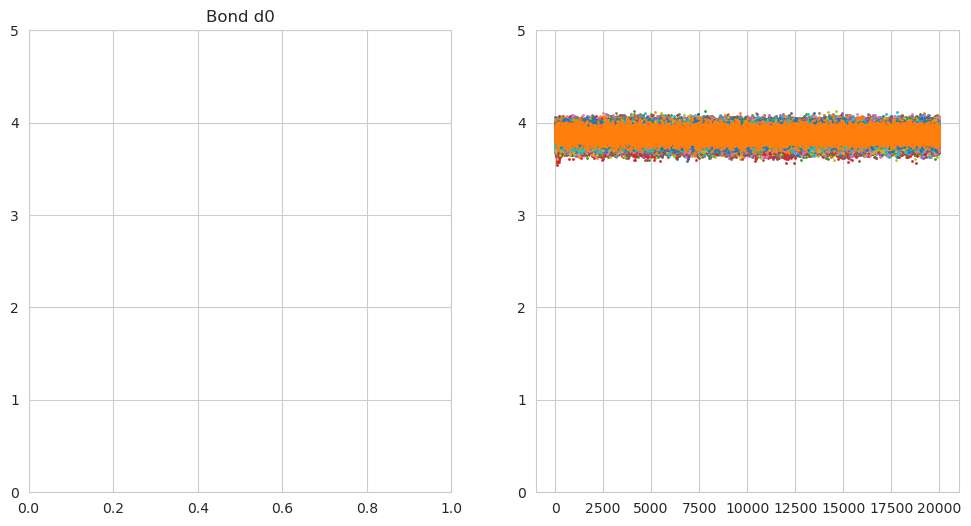

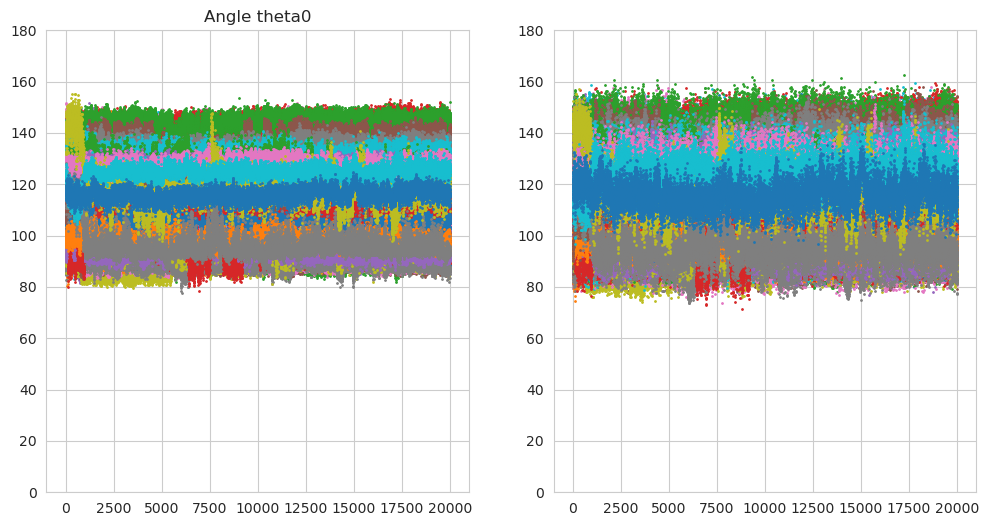

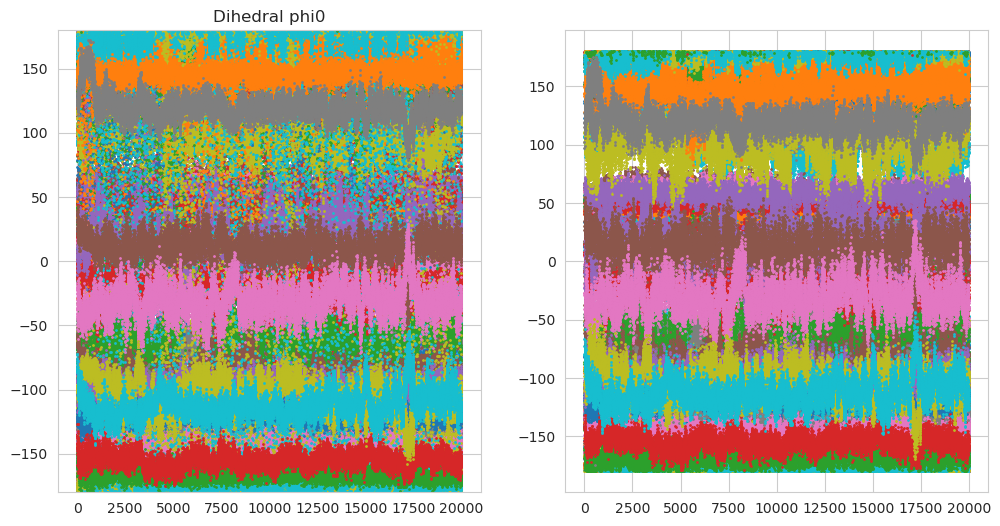

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in harmonic_predictions["bond_d0"].T:
    axes[0].scatter(range(len(i)), i, s=1)

axes[0].set_ylim(0,5)
axes[0].set_title("Bond d0")
for i in true_bonds.T:
    axes[1].scatter(range(len(i)), i, s=1)
axes[1].set_ylim(0,5)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in harmonic_predictions["angle_theta0"].T*180/np.pi:
    axes[0].scatter(range(len(i)), i, s=1)
axes[0].set_ylim(0,180)
axes[0].set_title("Angle theta0")
for i in true_angles.T*180/np.pi:
    axes[1].scatter(range(len(i)), i, s=1)
axes[1].set_ylim(0,180)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in harmonic_predictions["dihedral_phi0"].T*180/np.pi:
    # Wrap angles to the same range as mdtraj returns
    wrapped_i = (i + 180) % (2*180) - 180
    axes[0].scatter(range(len(i)), wrapped_i, s=1)
axes[0].set_ylim(-180, 180)
axes[0].set_title("Dihedral phi0")
for i in true_dihedrals.T*180/np.pi:
    axes[1].scatter(range(len(i)), i, s=1)
axes[0].set_ylim(-180, 180)
plt.show()

pass